In [6]:
fit_over_global_estimates = True
sim_years = [5000]
modelsel_add = '_only_global_models'
only_global_models = True
rgi_regs_global = ['All']
temp_ch = ''

pd_vol_2020 = pd.read_csv(f'../rgi_vs_2020_volume_hugonnet_estimates{DATE}.csv', index_col=[0])

vol_2020 = pd_vol_2020.loc['Globally', f'regional_volume_m3_2020{approach}']
vol_2020

152767463429916.1

In [7]:
vol_2020_reg

152767463429916.1

In [ ]:
pd_tt_single = (100*ds_reg_models_vol_roll.isel(year_after_2020=-1).sum(dim='rgi_reg')/vol_2020).to_dataframe().reset_index()
pd_tt_median = (100*ds_reg_models_vol_roll.isel(year_after_2020=-1).sum(dim='rgi_reg')/vol_2020).median(dim='model_author').to_dataframe().reset_index()

pd_global_temp_exp_m_r = pd_global_temp_exp_m.reset_index()
pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario'] = pd_global_temp_exp_m_r['gcm'] +'_'+pd_global_temp_exp_m_r['period_scenario']
pd_global_temp_exp_m_r.index = pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario']


pd_tt_median['gcm'+'_'+'period_scenario'] = pd_tt_median['gcm'] +'_'+pd_tt_median['period_scenario']
pd_tt_median.index = pd_tt_median['gcm'+'_'+'period_scenario']
pd_tt_median.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
pd_tt_median = pd_tt_median.reset_index(drop=True)

pd_tt_single['gcm'+'_'+'period_scenario'] = pd_tt_single['gcm'] +'_'+pd_tt_single['period_scenario']
pd_tt_single.index = pd_tt_single['gcm'+'_'+'period_scenario']
pd_tt_single.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
pd_tt_single = pd_tt_single.reset_index(drop=True)


In [ ]:
###########

fit_to_median = False # False

# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Feb12_2024' #'apr04' (has OGGM runaway effect of glaciers inside)
fill_option = 'repeat_last_101yrs' 
add_lowess=True
#avg_over = '100yr'
shift_years = True
temp_above_0_8_sel = False
approach = '_via_5yravg'
write_exp_text = True
qs = [0.05,0.25,0.5,0.75,0.95]

N = 500#0 #15#0 #150#150#50 #500 #100 #100 #100 #100#100
it = 2# 1#2 #1#2




import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from moepy import lowess, eda

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
f_path_data ='/home/users/lschuster/GlacierMIP3/'

f_path ='/home/users/lschuster/GlacierMIP3/2023_exploratory_analysis_notebooks/lowess_fits/'
f_path_f = '/home/users/lschuster/GlacierMIP3/2023_exploratory_analysis_notebooks/figures/2a_lowess_fits/'

try:
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)

except:
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models = xr.open_dataset(path_merged_runs_scaled_extend)
# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_ar6_isimip3b.csv', index_col = 0)

from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous

hue_order_anonymous = []
pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if only_global_models:
        if m in ['GLIMB', 'GloGEMflow', 'OGGM_v16', 'PyGEM-OGGM_v13']:
            hue_order.append(m)
            pal_models_l.append(p)
    else:
        if (m!='OGGM-VAS') and (m!='OGGM_v153') and (m!='Huss'):
            hue_order.append(m)
            pal_models_l.append(p)
        
        
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l
pal_models = sns.color_palette(pal_models)

   
ds_reg_models = ds_reg_models.sel(model_author=hue_order)
ds_reg_models_vol = ds_reg_models.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


pd_global_temp_exp_glac = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv', index_col = 0)

def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv(f'{f_path_data}data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    #print(_p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc'))
    _p = _p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc')
    return _p
np.testing.assert_allclose(get_glob_temp_exp(region='global')['temp_ch_ipcc'].values,
                                  pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()['temp_ch_ipcc'].values, rtol=1e-5)
import matplotlib
matplotlib.__version__

pd_rgi_stats_w_hugonnet = pd.read_csv(f'/home/users/lschuster/GlacierMIP3/2023_exploratory_analysis_notebooks/rgi_vs_2020_volume_hugonnet_estimates{DATE}.csv', index_col = [0])

ds_reg_yr_shift= xr.open_dataset(f'/home/www/lschuster/glacierMIP3_analysis/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')
ds_reg_yr_shift = ds_reg_yr_shift.sel(model_author = hue_order)

ds_reg_yr_shift_vol = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950)).volume_m3
ds_reg_yr_shift_vol_med = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950)).volume_m3.median(dim='model_author')

show_color_models = True
plt.rc('font', size=24)  


# option A: choose 20-year period before and do the average!
import numpy as np
from scipy.optimize import curve_fit

# Define the exponential decay function, want to ensure that it -> zero if temperature is large!!!


#rgi_regs_global = ['03']# 
current_deltaT = 1.2
df_quantiles_l = []
sel_l = []
if shift_years:
    p_shift = '_shift_years_rel_2020'
else:
    p_shift = ''


    
for temp_above_0_8 in [temp_above_0_8_sel]: #,False]: True

    for version in ['simple']:
        jj=0
        if version == 'simple':
            def exponential_decay(x, a, b):
                # avoind overflow -> does not work ... 
                exp_values = -b * x
                #exp_values = np.clip(exp_values, -709, 709)  # Clip values to avoid overflow
                return a * np.exp(exp_values) #+ c * np.exp(-d * x**2)#**c 
            param_bounds = ([0, 0], [1000, 5])
            pd_exp_decay_fits_simple = pd.DataFrame(index=np.arange(0,20*4,1),
                                                    columns=['rgi_reg','year',
                                                             'a_simple', 'b_simple'])

        else:
            def exponential_decay(x, a, b,c,d):
                exp_values_b = -b * x
                #exp_values_b = np.clip(exp_values_b, -709, 709)  # Clip values to avoid overflow

                exp_values_d = -d * x**2
                #exp_values_d = np.clip(exp_values_d, -709, 709)  # Clip values to avoid overflow
                return a * np.exp(exp_values_b) + c * np.exp(exp_values_d)#**c 
            param_bounds = ([0, 0,0,0], [1000, 5,1000, 5])
            pd_exp_decay_fits_adv = pd.DataFrame(index=np.arange(0,20*4,1),
                                                 columns=['rgi_reg','year',
                                                          'a_comp', 'b_comp',
                                                          'c_comp', 'd_comp'])
        sel_l = []
        df_quantiles_l = []
        for sim_year in sim_years: # 
            sel_l = []
            df_quantiles_l = []
            if sim_year <5000:
                avg_over = '21yr'
            else:
                avg_over = '101yr'
            if temp_above_0_8:
                add= '_temp_above_0_8'
            else:
                add = ''
    
            if sim_year==5000:
                v_n = r'$V_{\%,ss}$'
                state = 'Steady-state volume'
            elif sim_year == 50:
                v_n = r'$V_{\%,50yr}$'
                state = 'Volume after 50 years'
            elif sim_year == 100:
                v_n = r'$V_{\%,100yr}$'
                state = 'Volume after 100 years'
            elif sim_year == 300:
                v_n = r'$V_{\%,300yr}$'
                state = 'Volume after 300 years'
            elif sim_year ==500:
                v_n = r'$V_{\%,500yr}$'
                state = 'Volume after 500 years'
            if avg_over=='101yr':
                sim_year_avg = 101
            elif avg_over=='60yr':
                sim_year_avg = 60
            else:
                sim_year_avg = 21
            fig, axs = plt.subplots(5,4,figsize=(35,40), sharey=True) #, sharey='row') #, sharex=True)
                
            if not fit_over_global_estimates: #path_only_glob != '_only_global_models':
                if shift_years:
                    ds_reg_models_med_vol_roll = ds_reg_yr_shift_vol_med.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
                    ds_reg_models_vol_roll = ds_reg_yr_shift_vol.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
                else:
                    ds_reg_models_med_vol_roll = ds_reg_models_med_vol.rolling(simulation_year=sim_year_avg, center=True).mean().dropna(dim='simulation_year', how='all').sel(simulation_year=slice(0,sim_year))
                    ds_reg_models_vol_roll = ds_reg_models_vol.rolling(simulation_year=sim_year_avg, center=True).mean().dropna(dim='simulation_year', how='all').sel(simulation_year=slice(0,sim_year))
            else:
                # only global models !!! 
                ds_reg_models_med_vol_global = ds_reg_yr_shift_vol.dropna(dim='model_author', how='any').median(dim='model_author')
                ds_reg_models_med_vol_roll = ds_reg_models_med_vol_global.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
                ds_reg_models_vol_roll = ds_reg_yr_shift_vol.rolling(year_after_2020=sim_year_avg, center=True).mean().dropna(dim='year_after_2020', how='all').sel(year_after_2020=slice(0,sim_year))
                ds_reg_models_vol_roll = ds_reg_models_vol_roll.dropna(dim='model_author', how='any')
            for j, rgi_reg in enumerate(rgi_regs_global):
                if rgi_reg == 'All':
                    _rgi_reg = 'Globally'
                else:
                    _rgi_reg = rgi_reg
                vol_2020_reg = pd_rgi_stats_w_hugonnet.loc[_rgi_reg][f'regional_volume_m3_2020{approach}']

                if j<4:
                    ax = axs[0][j]
                elif j <8:
                    ax = axs[1][j-4]
                elif j <12:
                    ax = axs[2][j-8]
                elif j <16:
                    ax = axs[3][j-12]
                elif j <20:
                    ax = axs[4][j-16]
                    
                region = f'RGI{rgi_reg}_glacier'

                if rgi_reg == 'All':
                    # get the temp.
                    if temp_ch != 'regional_glacier':
                        pd_global_temp_exp_m = get_glob_temp_exp(region='global')
                    else:
                        pd_global_temp_exp_m = get_glob_temp_exp(region='global_glacier')
                    if not fit_over_global_estimates: #path_only_glob != '_only_global_models':
                        if shift_years:
                            # we have done the dropping of everything after 4950, so the last year should be fine 
                            ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.isel(year_after_2020=-1).sum(dim='rgi_reg')
                            # make sure that we only take here global models ... 
                            ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(year_after_2020=-1).dropna(dim='model_author')
                            ds_t2 = 100*ds_t2/vol_2020_reg
                            ds_t = 100*ds_reg_models_med_vol_sel/vol_2020_reg # TODO checkt that this is the sum ... 

                        else:
                            ds_reg_models_med_vol_sel = ds_reg_models_med_vol_roll.isel(simulation_year=-1).sum(dim='rgi_reg')
                            # make sure that we only take here global models ... 
                            ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(simulation_year=-1).dropna(dim='model_author')
                            ds_t2 = 100*ds_t2/ds_reg_models_vol.isel(simulation_year=0).sum(dim='rgi_reg', min_count=19)
                            ds_t = 100*ds_reg_models_med_vol_sel/ds_reg_models_med_vol.isel(simulation_year=0).sum(dim='rgi_reg')

                    
                    else:
                        # with global models -> first sum over the regions, and then do the 
                        if shift_years:
                            #  the median should here also be the median over the summed up values 
                            #ds_reg_models_med_vol_sel = ds_reg_models_vol_roll.isel(year_after_2020=-1).sum(dim='rgi_reg').median(dim='model_author')
                            # make sure that we only take here global models ... 
                            ds_t2 = ds_reg_models_vol_roll.sum(dim='rgi_reg', min_count=19).isel(year_after_2020=-1).dropna(dim='model_author')
                            ds_t2 = 100*ds_t2/vol_2020_reg
                            ds_t = ds_t2 #### 100*ds_reg_models_med_vol_sel/vol_2020_reg # TODO checkt that this is the sum ... 
                        else:
                            raise NotImplementedError()
                    
                    pd_tt2 = ds_t2.to_dataframe()
                    try:
                        pd_tt2 = pd_tt2.drop(columns=['gcm','period_scenario'])
                    except:
                        pass
                    pd_tt2 = pd_tt2.reset_index()
                else:
                    # get the temp. 
                    if temp_ch != 'regional_glacier':
                        pd_global_temp_exp_m = get_glob_temp_exp(region='global')
                    else:
                        pd_global_temp_exp_m = get_glob_temp_exp(region=region)

                    if fit_to_median:
                        if shift_years:
                            # TODO
                            ds_t2 = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(year_after_2020=-1).dropna(dim='model_author')
                            ds_t2 = 100*ds_t2/vol_2020_reg
                        else:
                            ds_t2 = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(simulation_year=-1).dropna(dim='model_author')
                            ds_t2 = 100*ds_t2/ds_reg_models_vol.isel(simulation_year=0).sel(rgi_reg=rgi_reg)
                        ds_t = ds_t2.median(dim='model_author') 

                        pd_tt2 = ds_t2.to_dataframe()
                        try:
                            pd_tt2 = pd_tt2.drop(columns=['gcm','period_scenario'])
                        except:
                            pass
                        pd_tt2 = pd_tt2.reset_index()
                    else:
                        if shift_years:
                            # TODO
                            ds_t = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(year_after_2020=-1).dropna(dim='model_author')
                            ds_t = 100*ds_t/vol_2020_reg
                        else:
                            ds_t = ds_reg_models_vol_roll.sel(rgi_reg=rgi_reg).isel(simulation_year=-1).dropna(dim='model_author')
                            ds_t = 100*ds_t/ds_reg_models_vol.isel(simulation_year=0).sel(rgi_reg=rgi_reg)
                pd_tt = ds_t.to_dataframe()
                try:
                    pd_tt = pd_tt.drop(columns=['gcm','period_scenario'])
                except:
                    pass
                pd_tt = pd_tt.reset_index()
                # much better if we create a gcm_period_scenario column to later assign the correct temp. series ... 
                pd_global_temp_exp_m_r = pd_global_temp_exp_m.reset_index()
                pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario'] = pd_global_temp_exp_m_r['gcm'] +'_'+pd_global_temp_exp_m_r['period_scenario']
                pd_global_temp_exp_m_r.index = pd_global_temp_exp_m_r['gcm'+'_'+'period_scenario']
                pd_tt2['gcm'+'_'+'period_scenario'] = pd_tt2['gcm'] +'_'+pd_tt2['period_scenario']
                pd_tt2.index = pd_tt2['gcm'+'_'+'period_scenario']
                pd_tt2.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
                pd_tt2 = pd_tt2.reset_index(drop=True)

                pd_tt['gcm'+'_'+'period_scenario'] = pd_tt['gcm'] +'_'+pd_tt['period_scenario']
                pd_tt.index = pd_tt['gcm'+'_'+'period_scenario']
                pd_tt.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
                pd_tt = pd_tt.reset_index(drop=True)
                
                wrong = False
                if wrong: 
                    if rgi_reg == 'All':
                        #pd_tt['temp_ch_ipcc']  = pd_global_temp_exp_m['temp_ch_ipcc'].values
                        pd_tt = pd_tt.groupby(['gcm', 'period_scenario']).mean()
                        pd_tt.loc[pd_global_temp_exp_m.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m.temp_ch_ipcc
                        pd_tt = pd_tt.reset_index()
                        for m in pd_tt2.model_author.unique():
                            pd_tt2.loc[pd_tt2.model_author == m, 'temp_ch_ipcc'] = pd_global_temp_exp_m['temp_ch_ipcc'].values
                    else:
                        if fit_to_median:
                            #pd_tt['temp_ch_ipcc']  = pd_global_temp_exp_m['temp_ch_ipcc'].values
                            pd_tt = pd_tt.groupby(['gcm', 'period_scenario']).mean()
                            pd_tt.loc[pd_global_temp_exp_m.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m.temp_ch_ipcc
                            pd_tt = pd_tt.reset_index()
                            for m in pd_tt2.model_author.unique():
                                pd_tt2.loc[pd_tt2.model_author == m, 'temp_ch_ipcc'] = pd_global_temp_exp_m['temp_ch_ipcc'].values
                        else:
                            for m in pd_tt.model_author.unique():
                                pd_tt.loc[pd_tt.model_author == m, 'temp_ch_ipcc'] = pd_global_temp_exp_m['temp_ch_ipcc'].values

                pd_tt_above0 = pd_tt #.loc[pd_tt.volume_m3>0]  ## probably it is ok to also fit the zero volume estimates 
                # if I want to remove the very uncertain experiments,
                # I still want to keep those that are near to 
                # 1.2°C. However, there are no experiments directly at 1.2°C
                # and only one at +1, so, we should rather do the fit with >= +0.8°C
                if temp_above_0_8:
                    pd_tt_above0 = pd_tt_above0.loc[pd_tt_above0['temp_ch_ipcc']>=0.8]
                temp = pd_tt_above0['temp_ch_ipcc'].values

                q = 'volume_m3' # this is actually the 'relative volume change (in %)'
                rel_vol = pd_tt_above0[q].values

                if rgi_reg == 'All':
                    ax.text(0.97, 0.97, 'Globally', color='grey',transform=ax.transAxes, fontsize=24, va='top', ha='right')
                else:
                    nam = d_reg_num_name[rgi_reg]
                    ax.text(0.97, 0.97, f'{nam} (RGI{rgi_reg})', color='grey',transform=ax.transAxes, fontsize=24, va='top', ha='right')

                ax.set_ylabel(f'{state} '+f'{v_n}'+'\n(in %, rel. to 2020)', fontsize=26)

                if show_color_models:                    
                    if rgi_reg=='All':
                        pd_ttx = pd_tt2
                        pd_ttxx = pd_tt
                        # add legend...
                        n_models = len(pd_ttx.model_author.unique())
                        line1 = Line2D([0], [0],
                                       label='median over global model estimates',
                                       color='black', ms=10, marker='o', lw=0,alpha = 0.8)
                        line2 = Line2D([0], [0], label=f'{n_models} individual global models', color='grey', ms=7, marker='s', lw=0,alpha = 0.6)
                        #add handles
                        handles= [line1, line2]
                        #add legend
                        leg2=ax.legend(handles=handles, loc = 'upper right', fontsize=16, bbox_to_anchor=(1,0.55))
                    else:
                        if fit_to_median:
                            pd_ttx = pd_tt2
                            pd_ttxx = pd_tt
                        else:
                            pd_ttx = pd_tt
                            pd_ttxx = pd_tt[['temp_ch_ipcc', 'volume_m3']].groupby(['temp_ch_ipcc']).median().reset_index()
                        n_models = len(pd_ttx.model_author.unique())
                        line1 = Line2D([0], [0], label='median', color='black', ms=10, marker='o', lw=0,alpha = 0.8)
                        line2 = Line2D([0], [0], label=f'{n_models} individual', color='grey', ms=7, marker='s', lw=0,alpha = 0.6)

                        #add handles
                        handles= [line1, line2]
                        #add legend
                        leg2=ax.legend(handles=handles, title='glacier models',
                                      loc = 'upper right', fontsize=16, title_fontsize=18, bbox_to_anchor=(1,0.55))
                    sns.scatterplot(ax=ax,x='temp_ch_ipcc',
                                    y='volume_m3', #'volume (km3)',
                                    data = pd_ttx,
                                    hue_order=hue_order,
                                    hue='model_author',
                                    palette=pal_models,
                                    legend=False, s=40, alpha = 0.6, marker='s')
                    # if globally, the median comes from all estimates (also from those models that are only available for some RGI regions ...)
                    pd_tt_median = (100*ds_reg_models_vol_roll.isel(year_after_2020=-1).sum(dim='rgi_reg')/vol_2020).median(dim='model_author').to_dataframe().reset_index()
                    pd_tt_median['gcm'+'_'+'period_scenario'] = pd_tt_median['gcm'] +'_'+pd_tt_median['period_scenario']
                    pd_tt_median.index = pd_tt_median['gcm'+'_'+'period_scenario']
                    pd_tt_median.loc[pd_global_temp_exp_m_r.index, 'temp_ch_ipcc'] = pd_global_temp_exp_m_r['temp_ch_ipcc']
                    pd_tt_median = pd_tt_median.reset_index(drop=True)
                    sns.scatterplot(ax=ax,
                                x='temp_ch_ipcc',
                                y='volume_m3', #'volume (km3)',
                                data = pd_tt_median,
                                color='black',
                                #hue='temp_ch_ipcc',
                                #palette='flare',
                                legend=False, s=80, alpha = 0.8)
                        
                else:
                    sns.scatterplot(ax=ax,
                                x='temp_ch_ipcc',
                                y='volume_m3', #'volume (km3)',
                                data = pd_tt,
                                color='black',
                                #hue='temp_ch_ipcc',
                                #palette='flare',
                                legend=False, s=80, alpha = 0.3)
                if temp_ch == 'regional_glacier':
                    ax.set_xlabel(r'$\Delta$T$_{reg,glacier-area}$ (°C, compared to pre-industrial)')
                else:
                    ax.set_xlabel(r'$\Delta$T$_{global}$ (°C, compared to pre-industrial)')
                #plt.plot(temp, rel_vol, 'o', alpha =0.2)

                x,y = temp, rel_vol
                    
                if rgi_reg=='04':
                    xx,yy = x,y
                # Perform the curve fitting
                popt, pcov = curve_fit(exponential_decay, x-current_deltaT, y,loss='soft_l1', f_scale=0.1, bounds = param_bounds)  # Lower and upper bounds for a and b)
                # Generate a higher density x range for plotting the fitted curve
                x_dense = np.linspace(x.min(), x.max(), 100)
                fit_vars = popt #c_opt

                # Extract the optimized parameters
                if version == 'simple':
                    a_opt, b_opt = popt #c_opt
                    # Compute the fitted y values
                    y_fitted = exponential_decay(x_dense-current_deltaT, a_opt, b_opt)

                    func_vars= f'{v_n}'+r'(ΔT)='+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$ΔT))' #\n+'+f'{c_opt:.1f}*exp(-{d_opt:.2f}*ΔT²)' #+{c_opt:.2f}'
                    #r'V$_{ss,rel}$(ΔT)=a$\cdot$e'+r'$^{-b\cdot(ΔT-1.2)}$'
                    if current_deltaT !=0:
                        if temp_ch == 'regional_glacier':
                            #func_vars= r'$V_{\%}$(ΔT$_{reg}$)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*('+r'ΔT$_{reg}$'+f'-{current_deltaT}°C))' 
                            func_vars= f'{v_n}'+r'(ΔT$_{reg}$)='+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$(ΔT$_{reg}$-'+f'{current_deltaT}°C))'

                            fs_label = 14
                        else:
                            #func_vars= r'$V_{\%}$(ΔT)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*(ΔT-{current_deltaT}°C))' 
                            func_vars= f'{v_n}'+r'(ΔT)='+f'{a_opt:.1f}'+r'$\cdot$'+f'exp(-{b_opt:.2f}'+r'$\cdot$(ΔT-'+f'{current_deltaT}°C))'
                            fs_label = 18
                        #\n+'+f'{c_opt:.1f}*exp(-{d_opt:.2f}*ΔT²)' #+{c_opt:.2f}'
                else:
                    a_opt, b_opt, c_opt, d_opt = popt
                    # Compute the fitted y values
                    y_fitted = exponential_decay(x_dense, a_opt, b_opt, c_opt, d_opt)
                    func_vars= 'V%(ΔT)='+f'{a_opt:.1f}*exp(-{b_opt:.2f}*ΔT)\n+'+f'{c_opt:.1f}*exp(-{d_opt:.2f}*ΔT²)' #+{c_opt:.2f}'
                ax.plot(x_dense, y_fitted, '-', label=func_vars,
                        color='black', lw=4)
                if write_exp_text: 
                    text = ''
                    for temp in [1.2,1.5,2.0,2.7, 4.0]:
                        if version == 'simple':
                            Ttemp_vol = int(exponential_decay(temp-current_deltaT, a_opt, b_opt).round(0)) #c_opt
                            num_x=0.91
                            num_y=0.5
                        else:
                            Ttemp_vol = int(exponential_decay(temp-current_deltaT, a_opt, b_opt, c_opt, d_opt).round(0)) #c_opt
                            num_x=0.91
                        if Ttemp_vol < 10:
                            Ttemp_vol = f'  {Ttemp_vol}'
                        if temp_ch == 'regional_glacier':
                            text = text+r'V$_{\%}$'+r'(ΔT$_{reg}$='+f'+{temp}°C)'+f'={Ttemp_vol}%\n'
                        else:
                            text = text+r'V$_{\%}$'+f'(ΔT='+f'{temp}°C)'+f'={Ttemp_vol}%\n'
                    ax.text(num_x, num_y, text, color='black',transform=ax.transAxes, fontsize=22, va='bottom', ha='right')
                #except:
                #    pass

                ax.legend(fontsize=fs_label, loc='upper right', bbox_to_anchor=(1,0.92))
                #if j<2:
                ax.add_artist(leg2)

                if version == 'simple':
                    pd_exp_decay_fits_simple.iloc[jj] = (rgi_reg,sim_year, a_opt, b_opt)
                else:
                    pd_exp_decay_fits_adv.iloc[jj] = (rgi_reg,sim_year, a_opt, b_opt, c_opt, d_opt)
                jj+=1

                ax.set_ylim([-2,150])
                if temp_ch == 'regional_glacier':
                    ax.set_xlim([pd_global_temp_exp_glac['temp_ch_ipcc'].min()*1.001, pd_global_temp_exp_glac['temp_ch_ipcc'].max()*1.001])
                    ax.set_ylim([-2,400])
                else:
                    ax.set_ylim([-2,150])

                if j<16:
                    ax.set_xlabel('')
                if j not in [0,4,8,12,16,20]:
                    ax.set_ylabel('')
                if add_lowess:
                    eval_x =np.arange(x.min().round(1), x.max()*1.001, 0.05)
                    df_quantiles_ll = []
                    for frac in np.arange(0.1,1,0.01): # change from 0.3 to 0.1 -> just to allow lower frac parameters... 
                        df_quantiles = lowess.quantile_model(x, y, x_pred=np.concatenate([eval_x,x]),
                                                             frac=frac, num_fits=N, robust_iters=it,
                                                         qs=qs)
                        q = 0.5 # selection criteria are still done via the median at the moment ... 
                        lowi = df_quantiles[q].copy()
                        lowi[lowi<0] = 0
                        #ax.plot(df_quantiles.iloc[:len(eval_x)].index, lowi.iloc[:len(eval_x)], #label=f'lowess, frac= {frac}',
                        #        alpha = 0.8, lw=1, color='grey', zorder=-1)
                        df_quantiles['frac'] = frac
                        df_quantiles['region'] = rgi_reg
                        df_quantiles['year'] = sim_year
                        df_quantiles['fit_to_median'] = fit_to_median
                        df_quantiles['temp_ch'] = temp_ch
                        df_quantiles['avg_over'] = avg_over
                        df_quantiles['it'] = it
                        df_quantiles['N'] = N
                        df_quantiles['fit_opt'] = 'lowess_fit'
                        df_quantiles['shift_years_2020'] = shift_years
                        #df_quantiles['version'] = version
                        #df_quantiles['y'] = np.NaN
                        df_quantiles['y'] = np.concatenate([np.repeat(np.NaN, len(eval_x)), y])
                        #df_quantiles.iloc[len(eval_x):,'y'] = y
                        #df_quantiles.loc[df_quantiles.iloc[len(eval_x):].index,'y'] = y
                        df_quantiles['add'] = add
                        df_quantiles[f'min_{q}_diff'] = (df_quantiles[q].iloc[:len(eval_x)-1].values - df_quantiles[q].iloc[1:len(eval_x)].values).min()
                        df_quantiles[f'min_{q}'] = df_quantiles[q].min()
                        df_quantiles[f'min_{q}_diff_above_zero'] = (lowi.iloc[:len(eval_x)-1].values - lowi.iloc[1:len(eval_x)].values).min()
                        df_quantiles['median_absolute_deviation'] =  np.abs(df_quantiles.iloc[len(eval_x):]['y'] - df_quantiles.iloc[len(eval_x):][0.5]).median()
                        df_quantiles['rmse'] =  np.sqrt(np.mean((df_quantiles.iloc[len(eval_x):]['y']-df_quantiles.iloc[len(eval_x):][0.5])**2))
                        #np.abs(df_quantiles.iloc[len(eval_x):]['y'] - df_quantiles.iloc[len(eval_x):][0.5]).median()

                        if np.all(df_quantiles[f'min_{q}_diff_above_zero']>=0):
                            df_quantiles['algorithm_sel'] = 'only_decreasing'
                            if df_quantiles[q].min()>=0:
                                #ax.plot(df_quantiles.iloc[:len(eval_x)].index, lowi.iloc[:len(eval_x)], #label=f'lowess, frac= {frac}',
                                #    alpha = 0.8, lw=1, color='red', zorder=-1)
                                df_quantiles['algorithm_sel'] = 'non_negative_and_decreasing'
                        else:
                            df_quantiles['algorithm_sel'] = 'not_selected'
                        df_quantiles_l.append(df_quantiles)
                        df_quantiles_ll.append(df_quantiles)
                    df_quantiles_ll_concat = pd.concat(df_quantiles_ll)
                    #sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.frac == df_quantiles_ll_concat[f'min_{q}_diff_above_zero'].min().frac]
                    if (df_quantiles_ll_concat['min_0.5'].max()>=0) and len(df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='non_negative_and_decreasing'])>=1:
                        _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='non_negative_and_decreasing']
                        min_mad = _sel['median_absolute_deviation'].min()
                        min_rmse = _sel['rmse'].min()

                        max_diff_above_zero = _sel[f'min_{q}_diff_above_zero'].max()

                        #sel = _sel.loc[_sel.median_absolute_deviation == min_mad]
                        sel = _sel.loc[_sel.rmse == min_rmse]
                        sel = sel.sort_values('x')
                        #ax.plot(sel.index, sel[0.5], color='darkgreen', lw=3)

                        #sel2 = _sel.loc[_sel[f'min_{q}_diff_above_zero'] == max_diff_above_zero]
                        #sel2 = sel2.sort_values('x')
                        #ax.plot(sel2.index, sel2[0.5], color='blue', lw=3)

                    elif len(df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='only_decreasing'])>=1:
                        _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.algorithm_sel=='only_decreasing']
                        max_min = _sel['min_0.5'].max()
                        sel = _sel.loc[_sel['min_0.5'] == max_min]
                        sel = sel.sort_values('x')
                        # set values below zero to zero 
                        assert len(sel)>0
                        #ax.plot(sel.index, sel[0.5], color='orange', lw=3)
                    else:
                        # if nothing else work, just use the fit that is the most
                        # "monotonically" decreasing ... 
                        _max_min_diff =df_quantiles_ll_concat.groupby('frac')[f'min_{q}_diff_above_zero'].min()
                        frac = _max_min_diff.idxmax().round(3)
                        _sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat.frac.round(3) == frac]
                        #_sel = df_quantiles_ll_concat.loc[df_quantiles_ll_concat[f'min_{q}_diff_above_zero']]
                        sel = _sel.sort_values('x')
                        # set values below zero to zero 
                        assert len(sel)>0
                        #ax.plot(sel.index, sel[0.5], color='yellow', lw=3)
                    
                    for qq in qs:
                        sel.loc[sel[qq]<0, qq] = 0
                    text = ''
                    for temp in [1.2,1.5,2.0,2.7, 4.0]:
                        num_y=0.5
                        try:
                            Ttemp_vol = int(sel.loc[np.round(sel.index,2)==temp, 0.5].round(0)) #c_opt                  
                            if Ttemp_vol < 10:
                                Ttemp_vol = f'  {Ttemp_vol}'
                        except:
                            Ttemp_vol = int(sel.loc[np.round(sel.index,2)==temp, 0.5].round(0).values[0]) 
                            if Ttemp_vol < 10:
                                Ttemp_vol = f'  {Ttemp_vol}'
                            # several values: let's just take the first one here (it is just for an 
                            # overview plot that is not used further) ... 
                        text = text + f'{Ttemp_vol}%\n'
                    ax.text(0.995, num_y, text, color='red',transform=ax.transAxes, fontsize=22, va='bottom', ha='right')
                    print(rgi_reg, sel.frac.unique())

                    ax.plot(sel.index, sel[0.5], color='red', lw=4)
                    if len(qs)>1 and rgi_reg != 'All':
                        #ax.fill_between(sel.index, sel[0.25], sel[0.75], color='red', alpha = 0.2)
                        ax.fill_between(sel.index, sel[0.25], sel[0.75], color='red', alpha = 0.25)
                        ax.fill_between(sel.index, sel[0.05], sel[0.95], color='red', alpha = 0.15)

                    sel_l.append(sel)
                    
                    if rgi_reg == '03':
                        plt.savefig(f'{f_path_f}{sim_year}test_{DATE}{modelsel_add}{temp_ch}.png')
            plt.tight_layout()
            if fit_to_median:
                add = add + '_fit_to_median'
            if add_lowess:
                add = add + '_lowess_added'
            if len(qs)>1:
                add = add + '_quantiles_added'
            if temp_ch != 'regional_glacier':
                plt.savefig(f'{f_path_f}2_glacier_volume_yr{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{version}{add}_current12deg_{DATE}{modelsel_add}_ipcc_ar6.png')
            else:
                plt.savefig(f'{f_path_f}2_glacier_volume_yr{p_shift}_{sim_year}_{avg_over}_avg_period_exp_decay_fit{version}{add}_current12deg_reg_glacier_temp_ch_{DATE}{modelsel_add}_ipcc_ar6.png')
            #if not test: 
            #    plt.close()
            
            pd_quantiles_concat = pd.concat(df_quantiles_l)
            pd_sel = pd.concat(sel_l)
            if fit_over_global_estimates:
                add = add + '_fit_over_global_estimates'
            if temp_ch != 'regional_glacier':
                pd_exp_decay_fits_simple.to_csv(f'{f_path}fitted_glacier_response_to_global_temp_ch_simple{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}_{DATE}{modelsel_add}_ipcc_ar6.csv')
                pd_quantiles_concat.to_csv(f'{f_path}fitted_lowess{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}_{DATE}{modelsel_add}_ipcc_ar6.csv')
                pd_sel.to_csv(f'{f_path}fitted_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}_{DATE}{modelsel_add}_ipcc_ar6.csv')
            else:
                pd_exp_decay_fits_simple.to_csv(f'{f_path}fitted_glacier_response_to_reg_glacier_temp_ch_simple{p_shift}_{avg_over}_avg_period{add}_current12deg_reg_glacier_temp_ch_{sim_year}_{DATE}{modelsel_add}_ipcc_ar6.csv')
                pd_quantiles_concat.to_csv(f'{f_path}fitted_lowess{p_shift}_{avg_over}_avg_period{add}_current12deg_reg_glacier_temp_ch_{sim_year}_{DATE}{modelsel_add}_ipcc_ar6.csv')
                pd_sel.to_csv(f'{f_path}fitted_lowess_best_frac{p_shift}_{avg_over}_avg_period{add}_current12deg_reg_glacier_temp_ch_{sim_year}_{DATE}{modelsel_add}_ipcc_ar6.csv')


  0%|                                                     | 0/5 [00:00<?, ?it/s]

In [9]:
pd_tt_median

,period_scenario,gcm,year_after_2020,volume_m3
0,1851-1870_hist,gfdl-esm4,4900.0,87.400615
1,1851-1870_hist,ipsl-cm6a-lr,4900.0,109.036776
2,1851-1870_hist,mpi-esm1-2-hr,4900.0,100.833512
3,1851-1870_hist,mri-esm2-0,4900.0,99.028687
4,1851-1870_hist,ukesm1-0-ll,4900.0,90.241208
...,...,...,...,...
75,2081-2100_ssp585,gfdl-esm4,4900.0,21.672226
76,2081-2100_ssp585,ipsl-cm6a-lr,4900.0,6.900080
77,2081-2100_ssp585,mpi-esm1-2-hr,4900.0,25.801620
78,2081-2100_ssp585,mri-esm2-0,4900.0,12.287537


In [55]:
len(rel_vol)

80

152767463429916.1

In [5]:
vol_2020_reg

152767463429916.1

In [11]:
pd_tt_median

,period_scenario,gcm,year_after_2020,volume_m3,gcm_period_scenario,temp_ch_ipcc
0,1851-1870_hist,gfdl-esm4,4900.0,87.400615,gfdl-esm4_1851-1870_hist,0.231409
1,1851-1870_hist,ipsl-cm6a-lr,4900.0,109.036776,ipsl-cm6a-lr_1851-1870_hist,-0.131913
2,1851-1870_hist,mpi-esm1-2-hr,4900.0,100.833512,mpi-esm1-2-hr_1851-1870_hist,0.083374
3,1851-1870_hist,mri-esm2-0,4900.0,99.028687,mri-esm2-0_1851-1870_hist,0.190948
4,1851-1870_hist,ukesm1-0-ll,4900.0,90.241208,ukesm1-0-ll_1851-1870_hist,0.373095
...,...,...,...,...,...,...
75,2081-2100_ssp585,gfdl-esm4,4900.0,21.672226,gfdl-esm4_2081-2100_ssp585,4.001455
76,2081-2100_ssp585,ipsl-cm6a-lr,4900.0,6.900080,ipsl-cm6a-lr_2081-2100_ssp585,5.849305
77,2081-2100_ssp585,mpi-esm1-2-hr,4900.0,25.801620,mpi-esm1-2-hr_2081-2100_ssp585,3.990799
78,2081-2100_ssp585,mri-esm2-0,4900.0,12.287537,mri-esm2-0_2081-2100_ssp585,4.594325


In [61]:
add

'_lowess_added_quantiles_added_fit_over_global_estimates'

In [59]:
pd_exp_decay_fits_simple = pd.read_csv(f'{f_path}fitted_glacier_response_to_global_temp_ch_simple{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}_{DATE}{modelsel_add}.csv')
pd_quantiles_concat = pd.read_csv(f'{f_path}fitted_lowess{p_shift}_{avg_over}_avg_period{add}_current12deg_{sim_year}_{DATE}{modelsel_add}.csv')


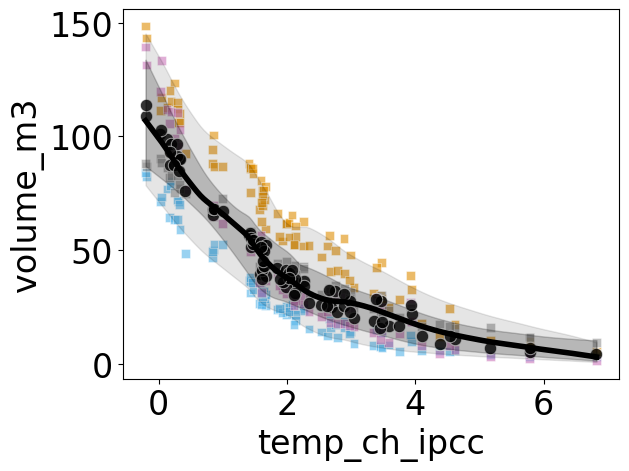

In [60]:
ax = plt.gca()

sns.scatterplot(ax=ax,x='temp_ch_ipcc',
                y='volume_m3', #'volume (km3)',
                data = pd_tt_single,
                hue_order=hue_order,
                hue='model_author',
                palette=pal_models,
                legend=False, s=40, alpha = 0.6, marker='s')

sns.scatterplot(ax=ax,
            x='temp_ch_ipcc',
            y='volume_m3', #'volume (km3)',
            data = pd_tt_median,
            color='black',
            #hue='temp_ch_ipcc',
            #palette='flare',
            legend=False, s=80, alpha = 0.8)

pd_sel = pd.read_csv(f'{f_path}fitted_lowess_best_frac{p_shift}_{avg_over}_avg_period_lowess_added_quantiles_added_fit_over_global_estimates_current12deg_{sim_year}_{DATE}{modelsel_add}.csv')
ax.fill_between(pd_sel.x, np.minimum.accumulate(pd_sel['0.25'].values),
                np.minimum.accumulate(pd_sel['0.75'].values),
                color='black', alpha = 0.2, label = '[25%. 75%]')
ax.fill_between(pd_sel.x,np.minimum.accumulate(pd_sel['0.05'].values),
                np.minimum.accumulate(pd_sel['0.95'].values),
                color='black', alpha = 0.1, label= '[ 5%. 95%]')
ax.plot(pd_sel.x, pd_sel['0.5'], color='black', lw=4, label='LOWESS fit')


,model_author,year_after_2020,period_scenario,gcm,volume_m3
0,PyGEM-OGGM_v13,50.0,1851-1870_hist,gfdl-esm4,1.441584e+14
1,PyGEM-OGGM_v13,50.0,1851-1870_hist,ipsl-cm6a-lr,1.528081e+14
2,PyGEM-OGGM_v13,50.0,1851-1870_hist,mpi-esm1-2-hr,1.477171e+14
3,PyGEM-OGGM_v13,50.0,1851-1870_hist,mri-esm2-0,1.502044e+14
4,PyGEM-OGGM_v13,50.0,1851-1870_hist,ukesm1-0-ll,1.498939e+14
...,...,...,...,...,...
1552315,GLIMB,4900.0,2081-2100_ssp585,gfdl-esm4,3.805869e+13
1552316,GLIMB,4900.0,2081-2100_ssp585,ipsl-cm6a-lr,1.767029e+13
1552317,GLIMB,4900.0,2081-2100_ssp585,mpi-esm1-2-hr,3.740050e+13
1552318,GLIMB,4900.0,2081-2100_ssp585,mri-esm2-0,2.507737e+13


/home/users/lschuster/.local/lib/python3.10/site-packages/xarray/core/dataarray.py:779: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


ValueError: Could not interpret value `temp_ch_ipcc` for parameter `x`

In [ ]:
                    sns.scatterplot(ax=ax,x='temp_ch_ipcc',
                                    y='volume_m3', #'volume (km3)',
                                    data = ds_reg_models_vol_roll,
                                    hue_order=hue_order,
                                    hue='model_author',
                                    palette=pal_models,
                                    legend=False, s=40, alpha = 0.6, marker='s')
                    # if globally, the median comes from all estimates (also from those models that are only available for some RGI regions ...)
                    sns.scatterplot(ax=ax,
                                x='temp_ch_ipcc',
                                y='volume_m3', #'volume (km3)',
                                data = ds_reg_models_med_vol_roll,
                                color='black',
                                #hue='temp_ch_ipcc',
                                #palette='flare',
                                legend=False, s=80, alpha = 0.8)

In [12]:
pd_sel.loc[]

,x,0.05,0.25,0.5,0.75,0.95,frac,region,year,fit_to_median,...,fit_opt,shift_years_2020,y,add,min_0.5_diff,min_0.5,min_0.5_diff_above_zero,median_absolute_deviation,rmse,algorithm_sel
0,-0.203529,101.426677,109.016853,110.591521,112.275478,114.073533,0.32,All,5000,False,...,lowess_fit,True,113.640414,NaN,0.090915,4.374399,0.090915,2.869281,4.145242,non_negative_and_decreasing
1,-0.200000,101.279720,108.856188,110.446913,112.135422,113.955500,0.32,All,5000,False,...,lowess_fit,True,NaN,NaN,0.090915,4.374399,0.090915,2.869281,4.145242,non_negative_and_decreasing
2,-0.191913,100.942473,108.488071,110.116186,111.814551,113.684739,0.32,All,5000,False,...,lowess_fit,True,109.036776,NaN,0.090915,4.374399,0.090915,2.869281,4.145242,non_negative_and_decreasing
3,-0.150000,99.183382,106.582015,108.415376,110.152243,112.274641,0.32,All,5000,False,...,lowess_fit,True,NaN,NaN,0.090915,4.374399,0.090915,2.869281,4.145242,non_negative_and_decreasing
4,-0.100000,97.059466,104.313808,106.409113,108.166779,110.575524,0.32,All,5000,False,...,lowess_fit,True,NaN,NaN,0.090915,4.374399,0.090915,2.869281,4.145242,non_negative_and_decreasing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,6.650000,3.497461,2.354248,4.699975,6.426606,18.575864,0.32,All,5000,False,...,lowess_fit,True,NaN,NaN,0.090915,4.374399,0.090915,2.869281,4.145242,non_negative_and_decreasing
217,6.700000,3.472014,2.217576,4.605880,6.242727,18.522436,0.32,All,5000,False,...,lowess_fit,True,NaN,NaN,0.090915,4.374399,0.090915,2.869281,4.145242,non_negative_and_decreasing
218,6.750000,3.451303,2.079949,4.511860,6.061941,18.468750,0.32,All,5000,False,...,lowess_fit,True,NaN,NaN,0.090915,4.374399,0.090915,2.869281,4.145242,non_negative_and_decreasing
219,6.800000,3.435976,1.941005,4.418952,5.886933,18.413892,0.32,All,5000,False,...,lowess_fit,True,NaN,NaN,0.090915,4.374399,0.090915,2.869281,4.145242,non_negative_and_decreasing
